<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/machine_learning/regression_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning resources

courses:
- http://materias.df.uba.ar/lda2021c1/171-2/
- https://www.kaggle.com/thirty-days-of-ml-assignments
- https://sebastianraschka.com/blog/2021/ml-course.html
- Coursera

Tutorials
- https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
- Feature importance: https://machinelearningmastery.com/calculate-feature-importance-with-python/

Books:
- introductory book: Deuschle, WJ (2019). Undergraduate Fundamentals of Machine Learning link here. It's like a basic version of Murphy (see below)
- Advanced: Murphy, K. P. (2022). Machine learning: a probabilistic perspective. link
James et al (2021). An Introduction to Statistical Learning: with Applications in R (Springer Texts in Statistics)

Other
- Deep dive into evaluation metrics of performance and related analyses:  Varoquaux, G., & Colliot, O. (2022). Evaluating machine learning models and their diagnostic value.
- More resources (statistics, NLP): https://docs.google.com/document/d/127Npk6Z2gV-p_ewwnRz7qDyvKKRI6vb6Yg3zKnOw16s/edit?usp=sharing
- Machine learning without programming: https://jasp-stats.org/



# Machine learning tutorial

Data from: Torrente, F., Yoris, A., Low, D., Lopez, P., Bekinschtein, P., Vázquez, G. H., ... & Cetkovich, M. (2022). Psychological symptoms, mental fatigue and behavioural adherence after 72 continuous days of strict lockdown during the COVID-19 pandemic in Argentina. BJPsych open, 8(1).

Data were collected between 21 May 2020 and 4 June 2020 (early pandemic). The survey reached 3617 adults (85.2% female) from all provinces of Argentina after 72 days of lockdown. In that period, Argentina had an Oxford stringency index of 85/100. Of those surveyed, 45.6% met the cut-offs for depression (10 or higher), that is, PHQ-9  levels were much higher than at the start of the pandemic (33.7% [Torrente et al. (2021). J Affect Disord]) and pre-pandemic (5.6%; [Daray et al. (2017). J Affect Disord]) in Argentine samples.

Here we can try to predict a participant's depression score (either ordinal or binary) from their other mental health and demographic data.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [37]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [28]:
# setting to see all columns
pd.set_option('display.max_columns', None)


# figure size in inches
rcParams['figure.figsize'] = 5,5

# Load data and set input/output paths

In [20]:
from os.path import exists
# config: depends whether you're on Google Colab or local


# Get URL from github csv by clicking on Download > Copy Link Address
# https://github.com/danielmlow/covid19_argentina/blob/main/data/input/Emotional%20symptoms%20COVID19_Arg_May20_v2_text.csv
df = pd.read_csv('https://github.com/danielmlow/covid19_argentina/raw/main/data/input/Emotional%20symptoms%20COVID19_Arg_May20_v2_text.csv')

load_from_google_drive = True

if load_from_google_drive:
  # On google colab
  # Mount GDrive and attach it to the colab for data I/O
  from google.colab import drive
  drive.mount('/content/drive')
  # input_dir = '/content/drive/My Drive/covid19_argentina/data/input/'
  output_dir = '/content/drive/My Drive/covid19_argentina/data/output/'
  os.makedirs(output_dir, exist_ok=True)

else:
  # If using jupyter-lab or jupyter notebook, load locally:
  input_dir = './data/input/'
  output_dir = './data/output/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [21]:
# select subset of variables
df = df[[
        'PHQ9_Total',
        'GAD7_Total',
        'Lockdown_adherence',
        'Age',
        'Gender', #added (binary)
        'Family_Income',  #added (ordinal)
        'Negat_thinking', #added (binary)
        'COGN_DIFFICULTIES_index',
        'Mental_fatigue', 'Threat', 'Riskofcontagion',
       'Lockdown_difficulty', 'Financialworry_present',
       'Financialworry_future', 'Daily_stress_Index', 'IU_total',
       'UCLA_LS_Total',
       ]]

df

,PHQ9_Total,GAD7_Total,Lockdown_adherence,Age,Gender,Family_Income,Negat_thinking,COGN_DIFFICULTIES_index,Mental_fatigue,Threat,Riskofcontagion,Lockdown_difficulty,Financialworry_present,Financialworry_future,Daily_stress_Index,IU_total,UCLA_LS_Total
0,8.0,5.0,9.0,24.0,1.0,2.0,1.0,2.0,8.0,3.0,3.0,7.0,4.0,4.0,1.0,27.0,9.0
1,9.0,7.0,10.0,25.0,2.0,1.0,1.0,5.0,23.0,6.0,4.0,8.0,7.0,4.0,2.0,43.0,21.0
2,8.0,1.0,10.0,20.0,1.0,3.0,1.0,5.0,9.0,3.0,1.0,1.0,10.0,10.0,2.0,13.0,0.0
3,13.0,13.0,10.0,19.0,1.0,2.0,1.0,3.0,16.0,2.0,1.0,7.0,5.0,3.0,-4.0,27.0,9.0
4,9.0,3.0,10.0,25.0,1.0,2.0,1.0,3.0,10.0,5.0,2.0,7.0,8.0,6.0,-1.0,35.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,11.0,12.0,9.0,66.0,1.0,1.0,1.0,5.0,11.0,9.0,7.0,4.0,9.0,5.0,-1.0,37.0,18.0
3613,7.0,4.0,6.0,67.0,1.0,2.0,0.0,1.0,9.0,7.0,6.0,7.0,8.0,6.0,2.0,25.0,5.0
3614,4.0,5.0,8.0,75.0,1.0,1.0,1.0,0.0,7.0,9.0,7.0,7.0,7.0,5.0,3.0,27.0,6.0
3615,8.0,10.0,8.0,70.0,1.0,2.0,1.0,6.0,12.0,8.0,7.0,7.0,9.0,7.0,-4.0,22.0,18.0


In [22]:
# Create dummy variable for categorical variable gender
gender = pd.get_dummies(df['Gender'],prefix='Gender')
display(gender)
display(gender.sum())

gender = pd.get_dummies(gender,prefix='Gender')
df = df.drop('Gender', axis=1)
df['Gender_female'] = gender['Gender_1.0']
# other genders were not included since there were only 9.


variables = df.columns.values
# df = df.astype(float)




,Gender_1.0,Gender_2.0,Gender_3.0
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3612,1,0,0
3613,1,0,0
3614,1,0,0
3615,1,0,0


Gender_1.0    3083
Gender_2.0     525
Gender_3.0       9
dtype: int64

In [23]:
# Provide clean names for manuscript table
print(variables)

# Use cleaner names in the final table

clean_names= dict(zip(
    variables,
    ['PHQ9', 'GAD7','Lockdown adherence','Age','Family income', 'Negative thinking','Cognitive troubles', 'Mental fatigue', 'Perceived threat', 'Perceived risk','Lockdown difficulty','Financial worries (present)','Financial worries (future)','Daily stress', 'Intolerance of uncertainty', 'Loneliness scale', 'Female', 'Male']

    ))

clean_names

['PHQ9_Total' 'GAD7_Total' 'Lockdown_adherence' 'Age' 'Family_Income'
 'Negat_thinking' 'COGN_DIFFICULTIES_index' 'Mental_fatigue' 'Threat'
 'Riskofcontagion' 'Lockdown_difficulty' 'Financialworry_present'
 'Financialworry_future' 'Daily_stress_Index' 'IU_total' 'UCLA_LS_Total'
 'Gender_female']


{'PHQ9_Total': 'PHQ9',
 'GAD7_Total': 'GAD7',
 'Lockdown_adherence': 'Lockdown adherence',
 'Age': 'Age',
 'Family_Income': 'Family income',
 'Negat_thinking': 'Negative thinking',
 'COGN_DIFFICULTIES_index': 'Cognitive troubles',
 'Mental_fatigue': 'Mental fatigue',
 'Threat': 'Perceived threat',
 'Riskofcontagion': 'Perceived risk',
 'Lockdown_difficulty': 'Lockdown difficulty',
 'Financialworry_present': 'Financial worries (present)',
 'Financialworry_future': 'Financial worries (future)',
 'Daily_stress_Index': 'Daily stress',
 'IU_total': 'Intolerance of uncertainty',
 'UCLA_LS_Total': 'Loneliness scale',
 'Gender_female': 'Female'}

# Descriptive statistics

In [24]:
df.columns

Index(['PHQ9_Total', 'GAD7_Total', 'Lockdown_adherence', 'Age',
       'Family_Income', 'Negat_thinking', 'COGN_DIFFICULTIES_index',
       'Mental_fatigue', 'Threat', 'Riskofcontagion', 'Lockdown_difficulty',
       'Financialworry_present', 'Financialworry_future', 'Daily_stress_Index',
       'IU_total', 'UCLA_LS_Total', 'Gender_female'],
      dtype='object')

In [25]:
# Observe the descriptive stats of the independent variables
df.drop('PHQ9_Total',axis=1).describe()

,GAD7_Total,Lockdown_adherence,Age,Family_Income,Negat_thinking,COGN_DIFFICULTIES_index,Mental_fatigue,Threat,Riskofcontagion,Lockdown_difficulty,Financialworry_present,Financialworry_future,Daily_stress_Index,IU_total,UCLA_LS_Total,Gender_female
count,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,7.033177,8.441803,47.310755,1.840752,0.735693,2.969035,10.442908,6.617639,5.447885,5.279513,6.909594,5.864805,0.425491,31.962123,8.664086,0.852364
std,5.171025,1.831086,12.765485,0.775430,0.441025,2.189863,4.095191,2.417796,2.502014,2.908373,2.455660,2.402000,2.930999,10.754010,6.675201,0.354788
min,0.000000,1.000000,18.000000,1.000000,0.000000,0.000000,5.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-8.000000,12.000000,0.000000,0.000000
25%,3.000000,8.000000,38.000000,1.000000,0.000000,1.000000,8.000000,5.000000,4.000000,3.000000,5.000000,4.000000,-2.000000,24.000000,3.000000,1.000000
50%,6.000000,9.000000,46.000000,2.000000,1.000000,3.000000,10.000000,7.000000,5.000000,5.000000,7.000000,6.000000,0.000000,31.000000,8.000000,1.000000
75%,10.000000,10.000000,56.000000,2.000000,1.000000,5.000000,12.000000,8.000000,7.000000,8.000000,9.000000,8.000000,2.000000,39.000000,13.000000,1.000000
max,21.000000,10.000000,95.000000,3.000000,1.000000,7.000000,25.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,60.000000,30.000000,1.000000


### Take a subsample of observations and variables for faster plotting

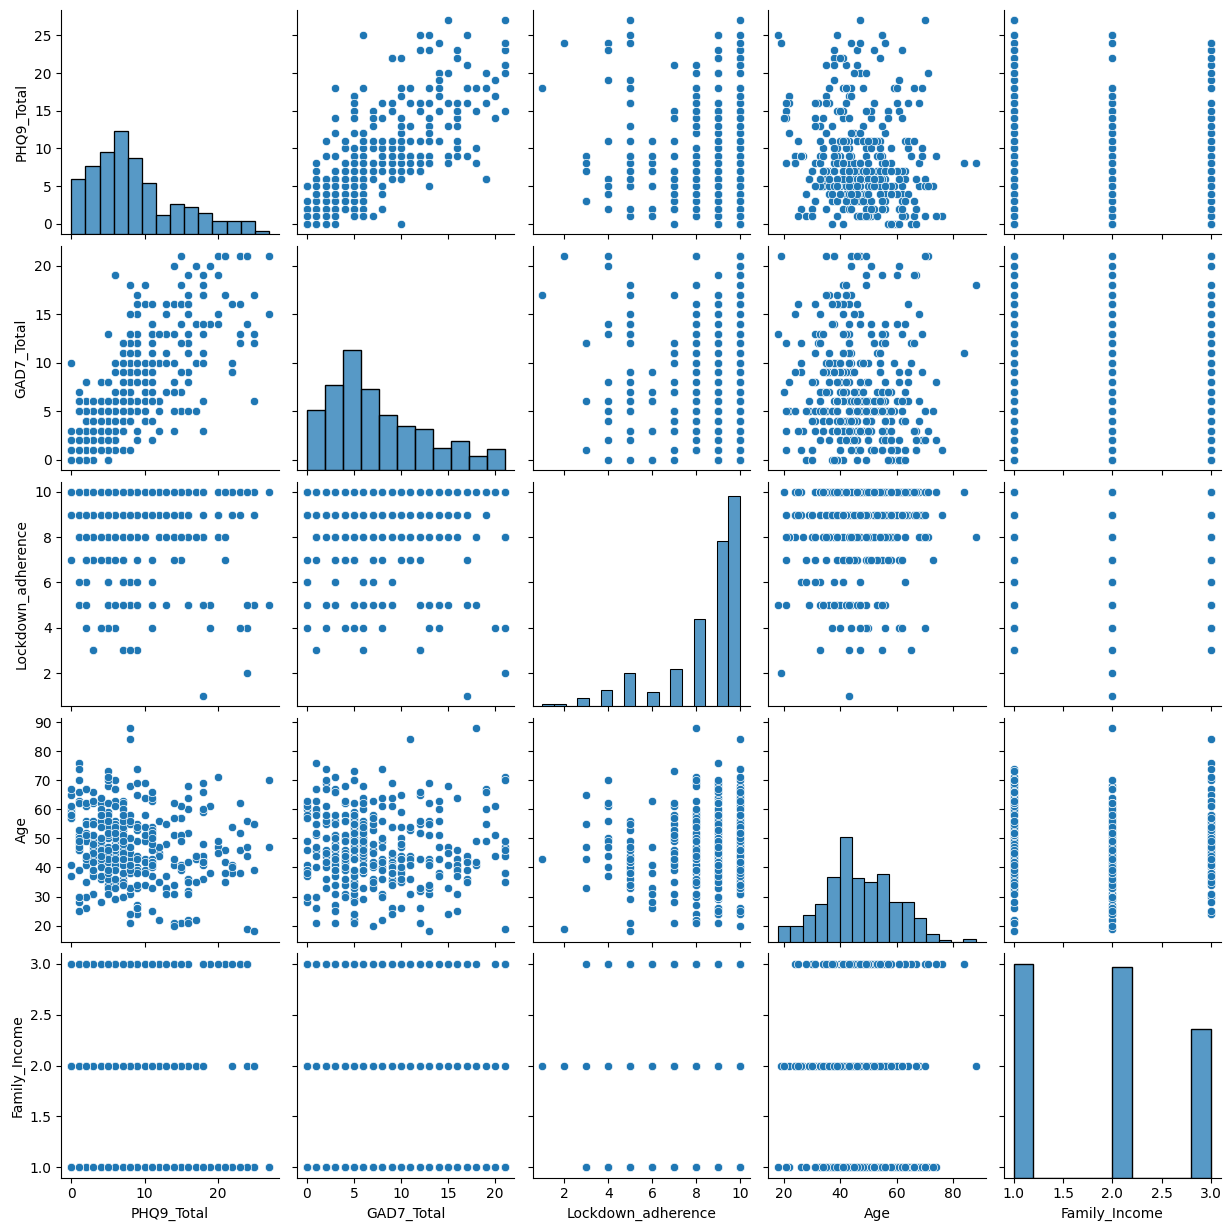

In [26]:
subsample = 0.1 # 0.1=10% of data, 1 = 100%
variables_to_plot = ['PHQ9_Total', 'GAD7_Total', 'Lockdown_adherence', 'Age',
       'Family_Income'] # It
df_subsample = df[variables_to_plot].sample(frac=subsample)
sns.pairplot(df_subsample)
plt.show()

### More thorough stats

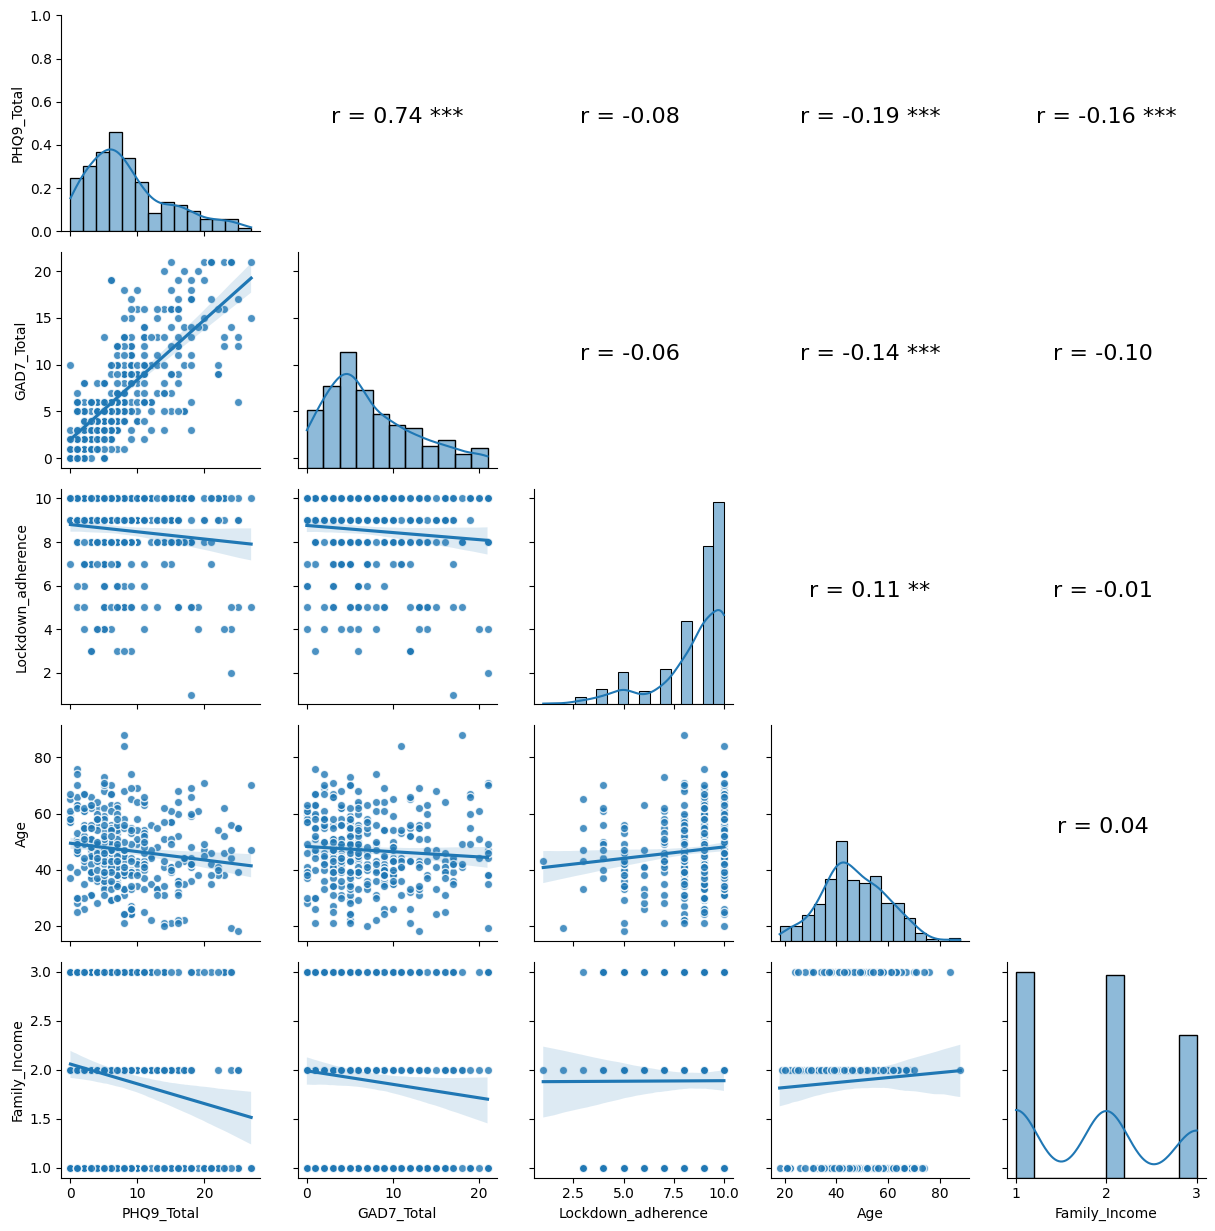

In [29]:
from scipy.stats import spearmanr


def reg_coef(x,y,label=None,color=None, **kwargs):
    ax = plt.gca()
    r,p = spearmanr(x,y)
    if p < 0.01:
        sig_level = '***'
    elif p < 0.05:
        sig_level = '**'
    elif p < 0.05:
        sig_level = '*'
    else:
        sig_level = ''

    ax.annotate('r = {:.2f} {}'.format(r, sig_level), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.texts[0].set_size(16)
    ax.set_axis_off()

# Create the plot
g = sns.PairGrid(data=df_subsample, vars=df_subsample.columns, hue=None)
g.map_upper(reg_coef)
g = g.map_lower(sns.regplot, scatter_kws={"edgecolor": "white"})
g = g.map_diag(sns.histplot, kde=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1544: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_k, label=label_k, color=color, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1544: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_k, label=label_k, color=colo

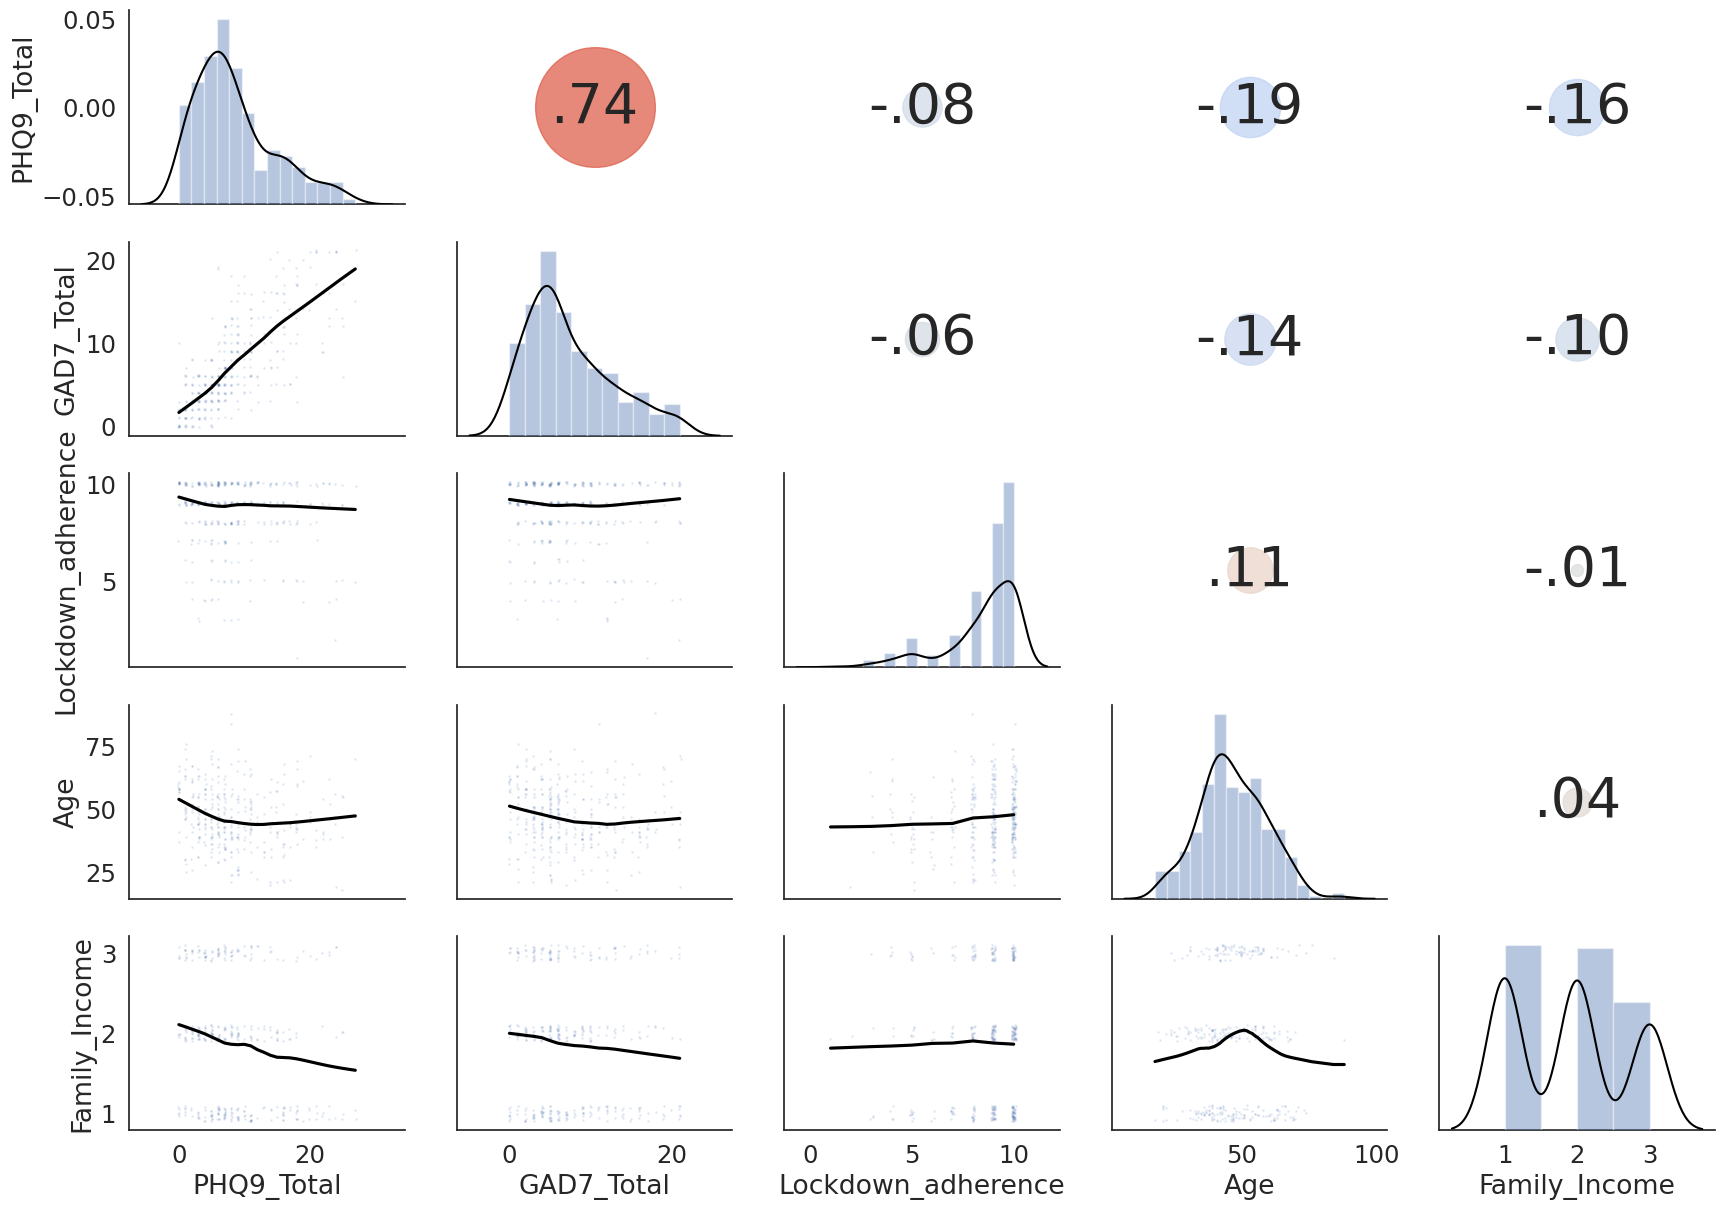

In [30]:

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.75, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 40 #abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)


# Pairwise correlation plot
sns.set(style='white', font_scale=1.6)
# iris = sns.load_dataset('iris')
g = sns.PairGrid(df_subsample, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=True, line_kws={'color': 'black'}, fit_reg=True,
          x_jitter=.1, y_jitter=.1,
            scatter_kws={"s": 1, "alpha":0.1}
            )
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

# Create DFs for each independent variable

In [31]:
def add_top_column(df, top_col, inplace=True):
    if not inplace:
        df = df.copy()

    df.columns = pd.MultiIndex.from_product([[top_col], df.columns])
    return df

In [81]:


# Depression

variables_depression = df.drop('PHQ9_Total',axis=1).columns.values
X = df.drop('PHQ9_Total',axis=1).values
feature_names = df.drop('PHQ9_Total',axis=1).columns
feature_names = [clean_names.get(n) for n in feature_names]
y = df['PHQ9_Total'].values
print('depression independent variables', variables_depression)
print(X.shape, y.shape)
print('\n\n')

# # Anxiety

# variables_anxiety = df.drop('GAD7_Total',axis=1).columns.values
# X_anxiety = df.drop('GAD7_Total',axis=1).values
# y_anxiety = df['GAD7_Total'].values
# print('Anxiety independent variables', variables_anxiety)
# print(X_anxiety.shape, y_anxiety.shape)
# print('\n\n')


# # Lockdown Adherence

# variables_lockdown = df.drop('Lockdown_adherence',axis=1).columns.values
# X_lockdown = df.drop('Lockdown_adherence',axis=1).values
# y_lockdown = df['Lockdown_adherence'].values
# print('Lockdown Adherence independent variables', variables_lockdown)
# print(X_lockdown.shape, y_lockdown.shape)
# print('\n\n')



depression independent variables ['GAD7_Total' 'Lockdown_adherence' 'Age' 'Family_Income' 'Negat_thinking'
 'COGN_DIFFICULTIES_index' 'Mental_fatigue' 'Threat' 'Riskofcontagion'
 'Lockdown_difficulty' 'Financialworry_present' 'Financialworry_future'
 'Daily_stress_Index' 'IU_total' 'UCLA_LS_Total' 'Gender_female']
(3617, 16) (3617,)





# Model evaluation

We're going to fit LASSO models and optimize the alpha or L1 parameter (regularization strength).

### Simple model


In [82]:
from sklearn.model_selection import train_test_split

model_name_i = 'Lasso_80-20'

# Held-out cross-validation 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)

model = Lasso()                # initializes model
model.fit(X_train,y_train)                             # fit model
intercept = model.intercept_                            # extract parameters
print('Intercept: ', np.round(intercept),4)
beta1 = model.coef_  [0]                               # intercept and slopes same as in the .summary2() output above
y_pred = model.predict(X_test)
r2 = metrics.r2_score(y_test,y_pred)
print('Beta 1: ', np.round(beta1))
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False )
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
round_to = 2
results_dict = {
    'y_train_min': np.min(y_train),
    'y_train_max': np.max(y_train),
    'RMSE':np.round(rmse,round_to ),
    'MAE':np.round(mae,round_to ),
    'R^2':np.round(r2,round_to ),
    }
results = pd.DataFrame(results_dict, index=[model_name_i]).round(3)
results


(2893, 16) (2893,)
Intercept:  -1.0 4
Beta 1:  1.0


,y_train_min,y_train_max,RMSE,MAE,R^2
Lasso_80-20,0.0,27.0,3.29,2.54,0.68


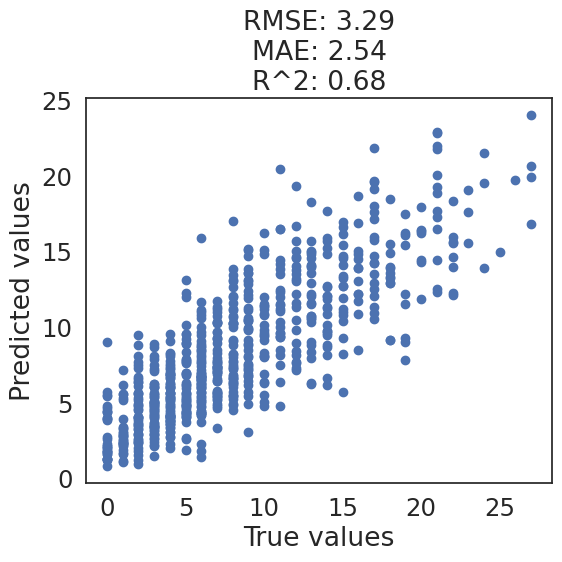

In [83]:


# Plot result for a regression task: true value vs predicted values
# ============================================================
plt.clf()
plt.scatter(y_test, y_pred)
plt.title(f"RMSE: {np.round(rmse,round_to )}\nMAE: {np.round(mae,round_to )}\nR^2: {np.round(r2,round_to )}"
        )
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.tight_layout()
# plt.savefig(f'results_{ts}/scatter_{model_name_i}_{ts}.png', dpi=150)
plt.show()


In [56]:

clean_names

{'PHQ9_Total': 'PHQ9',
 'GAD7_Total': 'GAD7',
 'Lockdown_adherence': 'Lockdown adherence',
 'Age': 'Age',
 'Family_Income': 'Family income',
 'Negat_thinking': 'Negative thinking',
 'COGN_DIFFICULTIES_index': 'Cognitive troubles',
 'Mental_fatigue': 'Mental fatigue',
 'Threat': 'Perceived threat',
 'Riskofcontagion': 'Perceived risk',
 'Lockdown_difficulty': 'Lockdown difficulty',
 'Financialworry_present': 'Financial worries (present)',
 'Financialworry_future': 'Financial worries (future)',
 'Daily_stress_Index': 'Daily stress',
 'IU_total': 'Intolerance of uncertainty',
 'UCLA_LS_Total': 'Loneliness scale',
 'Gender_female': 'Female'}

In [59]:
coefs = list(model.coef_)                     # Obtain coefficients from GridSearch
coefs= pd.DataFrame(coefs,index=feature_names, columns = ['Coef.']) # make DF
coefs['Abs. Coef.'] = coefs['Coef.'].abs()  # add column with absolute values to sort by, both positive and negative values are important.
coefs= coefs.sort_values('Abs. Coef.', ascending=False).reset_index() # sort by abs value and reset index to add a feature name column
coefs= coefs.drop(['Abs. Coef.'], axis=1)   # drop abs value, it's job is done
coefs.index +=1                             # Importance for publication, start index with 1 , as in 1st, 2nd, 3rd
coefs= coefs.reset_index()                  # turn index into column
coefs.columns= ['Importance', 'Feature', 'Std. Coef.'] # Clean column names
feature_importance = coefs.copy()
feature_importance

,Importance,Feature,Std. Coef.
0,1,GAD7,0.536938
1,2,Mental fatigue,0.371148
2,3,Cognitive troubles,0.120036
3,4,Loneliness scale,0.099028
4,5,Intolerance of uncertainty,0.019334
5,6,Daily stress,-0.013145
6,7,Age,-0.007376
7,8,Lockdown difficulty,0.004962
8,9,Lockdown adherence,-0.000000
9,10,Family income,-0.000000


### k-fold cross-validation

In [77]:
from sklearn.model_selection import KFold
splits = 5
kf = KFold(n_splits=splits, random_state=42, shuffle=True) # shuffle could be good if the data is ordered in same way (by ID, date) which could introduce bias.

scaler = StandardScaler()




y = np.array(y)                     # so I can index
results_mae = {}
results_r2 = {}
for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    model = Lasso()                # initializes model

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model.fit(X_train_scaled,y_train)                             # fit model

    y_pred = model.predict(X_test_scaled)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False )
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    round_to = 2
    results_dict = {
        f'MAE_{i}':np.round(mae,round_to ),
        f'R^2_{i}':np.round(r2,round_to ),
        }
    results_mae[f'MAE_{i}']=mae
    results_r2[f'R^2_{i}']=r2


In [78]:
r2_all = pd.DataFrame(results_r2, index = ['score'])
r2_all['R^2'] = r2_all.mean(axis=1).round(3)
display(r2_all)
mae_all = pd.DataFrame(results_mae, index = ['score'])
mae_all['MAE'] = mae_all.mean(axis=1).round(3)
display(mae_all)


,R^2_0,R^2_1,R^2_2,R^2_3,R^2_4,R^2
score,0.639136,0.628176,0.615483,0.593597,0.588972,0.613


,MAE_0,MAE_1,MAE_2,MAE_3,MAE_4,MAE
score,2.721222,2.738948,2.743474,2.789647,2.922024,2.783


### Hyperparameter tuning on training set

In [33]:
plt.rcParams["figure.figsize"] = (6,6)

In [85]:
# Train and test

model_name_i = 'Lasso_80-20_tuned'

#80-20 Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
alphas= np.logspace(-4, 0, 30) #equally spaced on log scale from 10**-4 (0.0004) to 10**0 (1)

# Pipeline: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

# hyperparameters and their values we're testing through gridsearch
param_grid = {
    'model__alpha': alphas,
}

# Do hyperparameter tuning within the training set, using 5-fold CV
search = GridSearchCV(pipe,param_grid, cv=5,n_jobs=-1) # perfrom k-fold CV on the training set

search.fit(X_train,y_train) # Train model
best_alpha = search.best_params_['model__alpha']
print('Best alpha: ', best_alpha)
# now use the best value to train the final model

# Train final model
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha = best_alpha))
])
pipe.fit(X_train,y_train) # train

# Test
y_pred = pipe.predict(X_test)

r2 = metrics.r2_score(y_test,y_pred)
print('Beta 1: ', np.round(beta1))
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False )
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
round_to = 2
results_dict = {
    'y_train_min': np.min(y_train),
    'y_train_max': np.max(y_train),
    'RMSE':np.round(rmse,round_to ),
    'MAE':np.round(mae,round_to ),
    'R^2':np.round(r2,round_to ),
    }
results = pd.DataFrame(results_dict, index=[model_name_i]).round(3)
display(results)





Best alpha:  0.03039195382313198
Beta 1:  1.0


,y_train_min,y_train_max,RMSE,MAE,R^2
Lasso_80-20_tuned,0.0,27.0,3.22,2.49,0.69


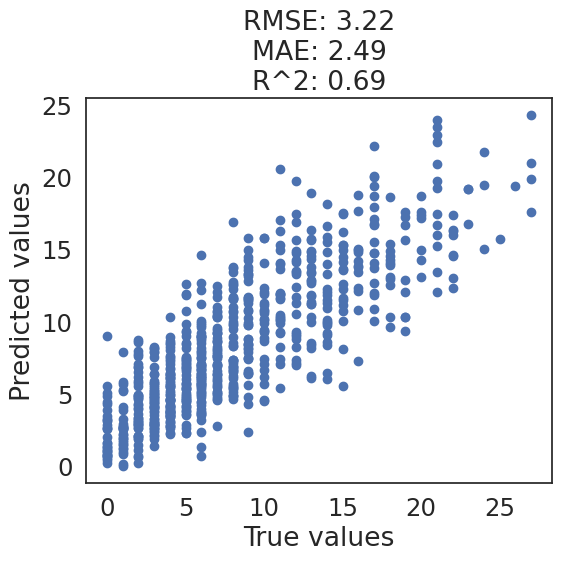

In [86]:
# Plot result for a regression task: true value vs predicted values
# ============================================================
plt.clf()
plt.scatter(y_test, y_pred)
plt.title(f"RMSE: {np.round(rmse,round_to )}\nMAE: {np.round(mae,round_to )}\nR^2: {np.round(r2,round_to )}"
        )
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.tight_layout()
# plt.savefig(f'results_{ts}/scatter_{model_name_i}_{ts}.png', dpi=150)
plt.show()


In [87]:
coefs = list(model.coef_)                     # Obtain coefficients from GridSearch
coefs= pd.DataFrame(coefs,index=feature_names, columns = ['Coef.']) # make DF
coefs['Abs. Coef.'] = coefs['Coef.'].abs()  # add column with absolute values to sort by, both positive and negative values are important.
coefs= coefs.sort_values('Abs. Coef.', ascending=False).reset_index() # sort by abs value and reset index to add a feature name column
coefs= coefs.drop(['Abs. Coef.'], axis=1)   # drop abs value, it's job is done
coefs.index +=1                             # Importance for publication, start index with 1 , as in 1st, 2nd, 3rd
coefs= coefs.reset_index()                  # turn index into column
coefs.columns= ['Importance', 'Feature', 'Std. Coef.'] # Clean column names
feature_importance = coefs.copy()
feature_importance

,Importance,Feature,Std. Coef.
0,1,GAD7,0.536938
1,2,Mental fatigue,0.371148
2,3,Cognitive troubles,0.120036
3,4,Loneliness scale,0.099028
4,5,Intolerance of uncertainty,0.019334
5,6,Daily stress,-0.013145
6,7,Age,-0.007376
7,8,Lockdown difficulty,0.004962
8,9,Lockdown adherence,-0.000000
9,10,Family income,-0.000000


# Classification

In [88]:
plt.rcParams["figure.figsize"] = (4,4)

In [89]:
import random
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score
from matplotlib.pyplot import figure
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

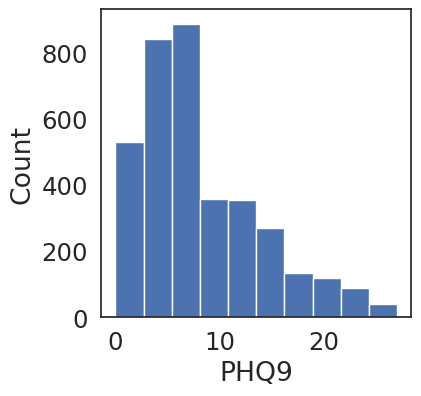

In [90]:
# plt.figure(figsize=(4,4))
plt.hist(y)
plt.xlabel('PHQ9')
plt.ylabel('Count')
plt.show()

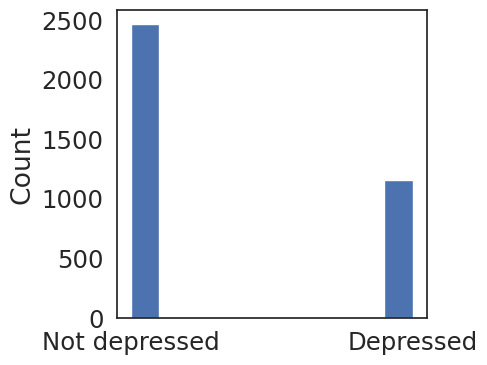

In [91]:
y_depression_binary = []
for i in y:
  if i >= 10:
    y_depression_binary.append(1)
  else:
    y_depression_binary.append(0)

y_depression_binary = np.array(y_depression_binary)
plt.hist(y_depression_binary)
plt.xticks(ticks = [0,1], labels = ['Not depressed', 'Depressed'])
plt.ylabel('Count')
plt.show()

In [92]:
Counter(y_depression_binary)

Counter({0: 2463, 1: 1154})

In [114]:

np.round(alphas,3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.001, 0.001,
       0.002, 0.002, 0.003, 0.005, 0.006, 0.009, 0.012, 0.016, 0.022,
       0.03 , 0.042, 0.057, 0.079, 0.108, 0.149, 0.204, 0.281, 0.386,
       0.53 , 0.728, 1.   ])

In [115]:
params_grid = [
              {
                'estimator':[LogisticRegression(class_weight='balanced', penalty = 'l1')],
                'estimator__C': [0.1, 0.3, 0.6, 0.9],
                },
                {
                'estimator':[SVC(class_weight='balanced',probability=True)],
                'estimator__C': [0.1, 1, 10],
                 'estimator__kernel': ['linear', 'rbf'],
                },
               # For the ROC AUC below, we need to output the probabilities
                # {
                # 'estimator': [RandomForestClassifier()],
                # 'estimator__n_estimators': [50, 250],
                # 'estimator__max_depth': [3,10],
                # },
               ]

In [99]:
len(X)

3617

In [110]:

print(len(y_pred), len(y_test))

724 724


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan 0.74131898 0.73724674 0.74172708 0.73770842 0.73797316
 0.73745717 0.70099515]
  warnings.warn(


=====
best parameters {'estimator': SVC(C=0.1, class_weight='balanced', probability=True), 'estimator__C': 0.1, 'estimator__kernel': 'rbf'}
=====
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       492
           1       0.77      0.78      0.77       232

    accuracy                           0.85       724
   macro avg       0.83      0.83      0.83       724
weighted avg       0.85      0.85      0.85       724

CPU times: user 2.33 s, sys: 143 ms, total: 2.47 s
Wall time: 59.8 s


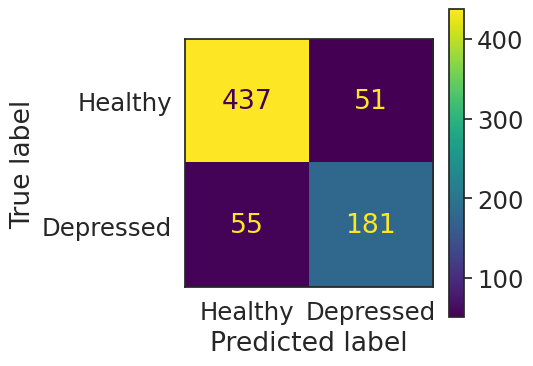

In [111]:
%%time
toy = False

if toy:
  # use a subsample
  m = 1000
  X_toy, y_depression_binary_toy = zip(*random.sample(list(zip(X, y_depression_binary)), m))
  X_train, X_test, y_train, y_test = train_test_split(X_toy, y_depression_binary_toy, test_size=0.2, random_state=42)
else:
  X_train, X_test, y_train, y_test = train_test_split(X, y_depression_binary, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('normalize', StandardScaler()),
    ('estimator', LogisticRegression(class_weight='balanced'))
    ])#initialize with any classifier, but then it will test all estimators specified in params_grid

# Train the grid search model, use refit, to refit the best params, scoring is what you want to optimize
gs = GridSearchCV(pipeline, params_grid, cv=5, n_jobs=-1, scoring='f1', refit=True).fit(X_train, y_train) # I use f1-score because it is less affected by class imbalance
# Best performing model and its corresponding hyperparameters
print('=====')
print('best parameters', gs.best_params_)
print('=====')

# Test data performance
y_proba = gs.predict_proba(X_test)       # Get predicted probabilities
y_proba = np.round(y_proba,2)               # round to 2 decimals
y_proba                                     # probabilitiesfor y=0 and y=1
y_proba_1 = y_proba[:,1]
y_pred = np.argmax(y_proba, axis=1) # in binary classification, threshold 0.5

print(classification_report(y_pred, y_test))
cm = confusion_matrix(y_test, y_pred, )

cm_display = ConfusionMatrixDisplay(cm, display_labels = ['Healthy', 'Depressed']).plot()
plt.grid(False)


In [119]:

# Custom classification report
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
specificity = metrics.recall_score(y_test, y_pred, pos_label=0)    # specificity is the recall of the negative class or control group
f1 = metrics.f1_score(y_test, y_pred)
roc_auc = metrics.roc_auc_score(y_test, y_proba_1)  # IMPORTANT: other metrics take binary predictions y_pred. Here we test different thresholds, so we need probabilities (this will change the ROC AUC score)

results_dict = {
    'Precision':precision,
    'Recall':recall,
    'Specificity':specificity,
    'F1':f1,
    'ROC AUC':roc_auc,
    }

results = pd.DataFrame(results_dict, index=['model']).round(3)
results['best_params'] =  str(gs.best_params_)
results

,Precision,Recall,Specificity,F1,ROC AUC,best_params
model,0.78,0.767,0.895,0.774,0.914,"{'estimator': SVC(C=0.1, class_weight='balance..."


### Classification permutation import

<Figure size 3600x2400 with 0 Axes>

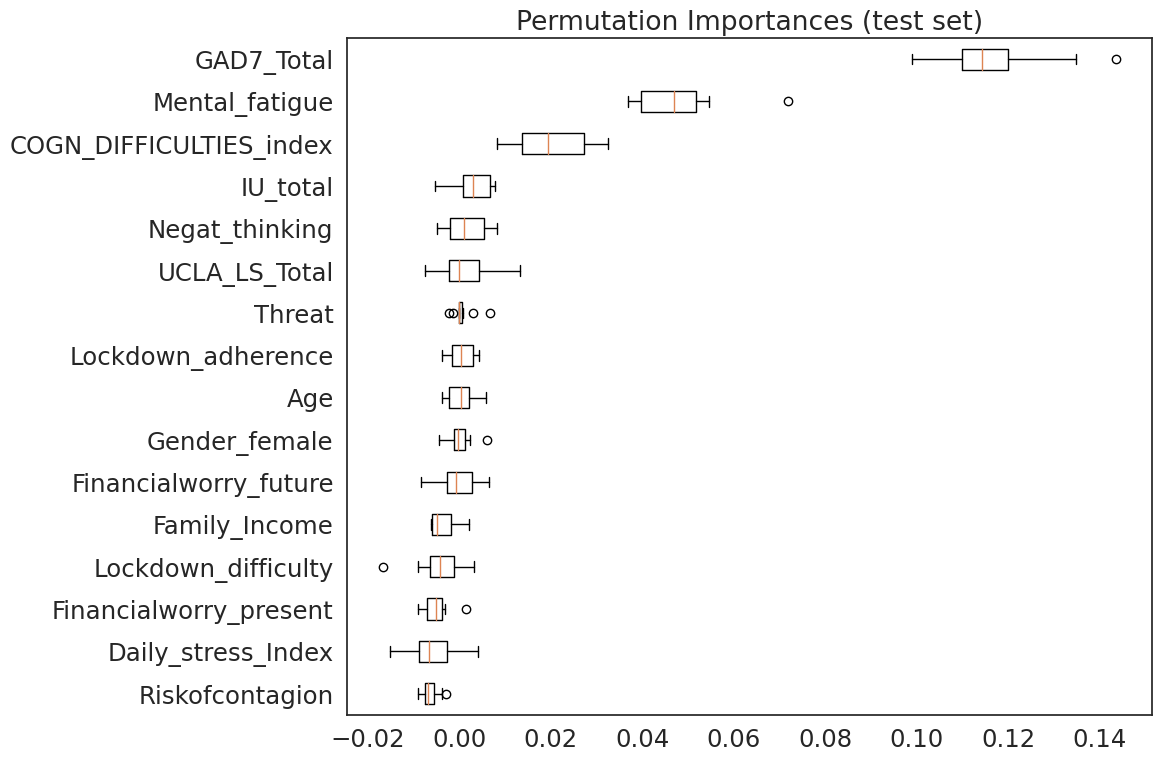

In [121]:


result = permutation_importance(gs, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)

figure(figsize=(12,8), dpi=300)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=variables_depression[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Extensions
- feature importance: permutation importance, LOFO
- Generalized Additive Model
- Speech, vision data
- RandomizedSearchCV instead of GridSearchCV
- autoML and auto sklearn
- nested cross-validation for hyperparameter tuning
- repeated measures
  - group shuffle split
  - time series cross-validation